In [2]:
import pandas as pd
from mplsoccer import Sbopen, Pitch
import numpy as np
import math

In [3]:
parser = Sbopen()
df_match = parser.match(competition_id=37, season_id=42)
match_ids = df_match.match_id.unique()

In [4]:
all_events_df = []
for match_id in match_ids:
    events = parser.event(match_id)[0]
    # Filter for shot events that are free kicks
    free_kick_shots = events[(events['type_name'] == 'Shot') & (events['sub_type_name'] == '')]
    all_events_df.append(free_kick_shots)
df_shot = pd.concat(all_events_df, ignore_index=True)
df_shot.columns.tolist()

['id',
 'index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'duration',
 'match_id',
 'type_id',
 'type_name',
 'possession_team_id',
 'possession_team_name',
 'play_pattern_id',
 'play_pattern_name',
 'team_id',
 'team_name',
 'tactics_formation',
 'player_id',
 'player_name',
 'position_id',
 'position_name',
 'pass_recipient_id',
 'pass_recipient_name',
 'pass_length',
 'pass_angle',
 'pass_height_id',
 'pass_height_name',
 'end_x',
 'end_y',
 'sub_type_id',
 'sub_type_name',
 'body_part_id',
 'body_part_name',
 'x',
 'y',
 'under_pressure',
 'outcome_id',
 'outcome_name',
 'aerial_won',
 'counterpress',
 'out',
 'ball_recovery_recovery_failure',
 'pass_assisted_shot_id',
 'pass_shot_assist',
 'shot_statsbomb_xg',
 'end_z',
 'shot_key_pass_id',
 'technique_id',
 'technique_name',
 'goalkeeper_position_id',
 'goalkeeper_position_name',
 'pass_no_touch',
 'foul_committed_advantage',
 'foul_won_advantage',
 'pass_goal_assist',
 'foul_won_defensive',
 'pass_cut_back'

In [11]:
import pandas as pd
import numpy as np

# Assuming you're using StatsBomb's data parser
def extract_free_kicks(parser, competition_ids, season_ids):
    """
    Extract free kick shots from multiple competitions and seasons

    Parameters:
    parser - StatsBomb parser object
    competition_ids - list of competition IDs
    season_ids - list of season IDs for each competition (should match length of competition_ids)

    Returns:
    DataFrame with free kick data
    """
    all_free_kicks = []

    for comp_id, season_id in zip(competition_ids, season_ids):
        print(f"Processing competition {comp_id}, season {season_id}...")

        # Get all matches for this competition/season
        df_match = parser.match(competition_id=comp_id, season_id=season_id)
        match_ids = df_match.match_id.unique()

        for match_id in match_ids:
            try:
                # Get events for this match
                events = parser.event(match_id)[0]

                # Filter for shot events that are free kicks
                free_kick_shots = events[(events['type_name'] == 'Shot')].copy()  # Create explicit copy

                # Add match and competition context
                if not free_kick_shots.empty:
                    match_info = df_match[df_match.match_id == match_id].iloc[0]
                    free_kick_shots.loc[:, 'competition_name'] = match_info['competition_name']
                    free_kick_shots.loc[:, 'season_name'] = match_info['season_name']
                    free_kick_shots.loc[:, 'home_team'] = match_info['home_team_name']
                    free_kick_shots.loc[:, 'away_team'] = match_info['away_team_name']

                    all_free_kicks.append(free_kick_shots)
            except Exception as e:
                print(f"Error processing match {match_id}: {e}")

    # Combine all free kicks into a single DataFrame
    if all_free_kicks:
        df_free_kicks = pd.concat(all_free_kicks, ignore_index=True)
        return df_free_kicks
    else:
        return pd.DataFrame()

def process_free_kick_data(df_free_kicks):
    """
    Process and clean free kick data
    """
    # Create a working copy to avoid warnings
    df = df_free_kicks.copy()

    # Create a binary target variable for goals
    df.loc[:, 'is_goal'] = df['outcome_name'].apply(lambda x: 1 if x == 'Goal' else 0)

    # Calculate shot angle and distance
    df.loc[:, 'shot_angle'] = df.apply(
        lambda row: calculate_angle(row['x'], row['y']), axis=1)

    df.loc[:, 'shot_distance'] = df.apply(
        lambda row: calculate_distance(row['x'], row['y']), axis=1)

    # Extract body part used for the shot as a feature
    df.loc[:, 'body_part'] = df['body_part_name']

    # Determine if the shot was on the left or right side of the field
    df.loc[:, 'side_of_field'] = df['y'].apply(
        lambda y: 'left' if y < 40 else ('right' if y > 40 else 'center'))

    # Determine shot technique
    df.loc[:, 'shot_technique'] = df['technique_name']

    # Extract time features
    df.loc[:, 'game_period'] = df['period']
    df.loc[:, 'game_minute'] = df['minute']

    # Select important columns for the CSV
    selected_columns = [
        # Identifiers and context
        'id', 'match_id', 'competition_name', 'season_name',



        # Shot details
        'x', 'y', 'shot_distance', 'shot_angle',
        'body_part', 'side_of_field',

        # Shot outcomes
        'is_goal', 'outcome_name', 'shot_statsbomb_xg',


    ]

    # Filter only existing columns (in case some are missing)
    existing_columns = [col for col in selected_columns if col in df.columns]

    return df[existing_columns]

# Define the angle and distance calculation functions
def calculate_angle(x, y):
    """Calculate the angle of the shot in degrees"""
    # 44 and 36 is the location of each goal post
    g0 = [120, 44]  # Right goal post
    p = [x, y]      # Shot position
    g1 = [120, 36]  # Left goal post
    v0 = np.array(g0) - np.array(p)
    v1 = np.array(g1) - np.array(p)
    angle = np.math.atan2(np.linalg.det([v0,v1]), np.dot(v0,v1))
    return abs(np.degrees(angle))

def calculate_distance(x, y):
    """Calculate the distance to goal in StatsBomb units"""
    x_dist = 120-x
    y_dist = 0
    if (y<36):
        y_dist = 36-y
    elif (y>44):
        y_dist = y-44
    return np.sqrt(x_dist**2 + y_dist**2)

# Main execution
def create_free_kick_dataset():
    # Initialize the StatsBomb parser
    parser = Sbopen()

    # Define competitions and seasons to include
    # Example: [(English Premier League, 2020/21), (La Liga, 2020/21), etc.]
    competitions_seasons = [
        (2, 44),    # Example: La Liga 2020/21
        (37, 42),   # Premier League 2019/20
        (43, 3),    # World Cup 2018
        # Add more competitions as needed
    ]

    competition_ids = [comp for comp, _ in competitions_seasons]
    season_ids = [season for _, season in competitions_seasons]

    # Extract free kick data
    free_kicks_df = extract_free_kicks(parser, competition_ids, season_ids)

    if not free_kicks_df.empty:
        # Process and clean the data
        processed_df = process_free_kick_data(free_kicks_df)

        # Save to CSV
        processed_df.to_csv('all_kicks_dataset.csv', index=False)
        print(f"Dataset created with {len(processed_df)} free kicks.")

        # Generate some summary statistics
        print("\nSummary Statistics:")
        goals = processed_df['is_goal'].sum()
        total = len(processed_df)
        print(f"Total free kicks: {total}")
        print(f"Goals: {goals} ({goals/total*100:.2f}%)")
        print(f"Average distance: {processed_df['shot_distance'].mean():.2f}")
        print(f"Average xG: {processed_df['shot_statsbomb_xg'].mean():.4f}")

        # Optional: create categorical distance and angle features
        processed_df.loc[:, 'distance_category'] = pd.cut(
            processed_df['shot_distance'],
            bins=[0, 20, 25, 30, 35, 100],
            labels=['Very Close', 'Close', 'Medium', 'Far', 'Very Far']
        )

        processed_df.loc[:, 'angle_category'] = pd.cut(
            processed_df['shot_angle'],
            bins=[0, 3, 6, 10, 15, 30],
            labels=['Terrible', 'Poor', 'Fair', 'Good', 'Great']
        )

        # Save enhanced version with categories
        processed_df.to_csv('all_kicks_dataset_enhanced.csv', index=False)

        return processed_df
    else:
        print("No free kick data found.")
        return None

# Execute if run as script
if __name__ == "__main__":
    create_free_kick_dataset()

Processing competition 2, season 44...
Processing competition 37, season 42...
Processing competition 43, season 3...


C:\Users\ebrah\AppData\Local\Temp\ipykernel_53384\3297877470.py:115: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]), np.dot(v0,v1))


Dataset created with 4858 free kicks.

Summary Statistics:
Total free kicks: 4858
Goals: 529 (10.89%)
Average distance: 18.14
Average xG: 0.1097


In [4]:
# df_shot.columns.to_list()
# df_goals = df_shot[df_shot.outcome_name == 'Goal'][['x', 'y', 'outcome_name', 'shot_statsbomb_xg']].copy()
#
#
# df_non_goal_shots = df_shot[df_shot.outcome_name != 'Goal'][['x', 'y', 'outcome_name', 'shot_statsbomb_xg']].copy()
# df_non_goal_shots['outcome_name'] = 'No Goal'

In [5]:
# def calculate_angle(x, y):
#   # 44 and 36 is the location of each goal post
#   g0 = [120, 44]
#   p = [x, y]
#   g1 = [120, 36]
#
#   v0 = np.array(g0) - np.array(p)
#   v1 = np.array(g1) - np.array(p)
#
#   angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
#   return(abs(np.degrees(angle)))
#
# def calculate_distance(x, y):
#   x_dist = 120-x
#   y_dist = 0
#   if (y<36):
#     y_dist = 36-y
#   elif (y>44):
#     y_dist = y-44
#   return math.sqrt(x_dist**2 + y_dist**2)

In [6]:
# df_goals['distance'] = df_goals.apply(lambda row: calculate_distance(row['x'], row['y']), axis=1)
# df_goals['angle'] = df_goals.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
#
# # Add distance and angle columns to df_non_goal_shots
# df_non_goal_shots['distance'] = df_non_goal_shots.apply(lambda row: calculate_distance(row['x'], row['y']), axis=1)
# df_non_goal_shots['angle'] = df_non_goal_shots.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)

C:\Users\ebrah\AppData\Local\Temp\ipykernel_9204\805757160.py:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
C:\Users\ebrah\AppData\Local\Temp\ipykernel_9204\805757160.py:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))


In [7]:
# df = pd.concat([df_goals, df_non_goal_shots], axis=0)
#
# # Reset index (optional)
# df = df.reset_index(drop=True)
# df


,x,y,outcome_name,shot_statsbomb_xg,distance,angle
0,93.6,75.6,Goal,0.005921,41.176692,6.186767
1,101.2,40.0,Goal,0.121448,18.800000,24.022957
2,97.6,51.2,Goal,0.074687,23.528706,16.340806
3,90.2,53.7,Goal,0.015563,31.338953,12.678364
4,100.5,26.2,Goal,0.068447,21.824069,15.708010
...,...,...,...,...,...,...
65,83.7,38.0,No Goal,0.012272,36.300000,12.539122
66,94.1,26.1,No Goal,0.041974,27.727604,13.730289
67,86.0,35.3,No Goal,0.020629,34.007205,13.173558
68,108.5,15.3,No Goal,0.008374,23.679949,7.218783


In [8]:
# summary_stats = df.groupby('outcome_name')[['distance', 'angle']].mean().round(2)
# print(summary_stats)

              distance  angle
outcome_name                 
Goal             27.17  15.24
No Goal          28.61  13.54


Dataset shape: (4858, 15)

Target distribution:
is_goal
0    89.110745
1    10.889255
Name: proportion, dtype: float64

Missing values:
angle_category    1280
dtype: int64

Numerical features statistics:
                 x            y  shot_distance   shot_angle  shot_statsbomb_xg
count  4858.000000  4858.000000    4858.000000  4858.000000        4858.000000
mean    103.332606    39.946398      18.138927    25.477111           0.109747
std       9.088591    10.231384       9.159804    17.071912           0.157346
min      58.000000     0.700000       0.500000     0.000000           0.000180
25%      96.800000    32.300000      11.000000    14.483334           0.025775
50%     104.600000    40.000000      17.114321    19.139205           0.057120
75%     110.800000    47.400000      24.867046    31.600482           0.114652
max     120.000000    79.400000      70.566919   150.255119           0.991865

Correlation with target (is_goal):
                   correlation
shot_statsbomb_xg 

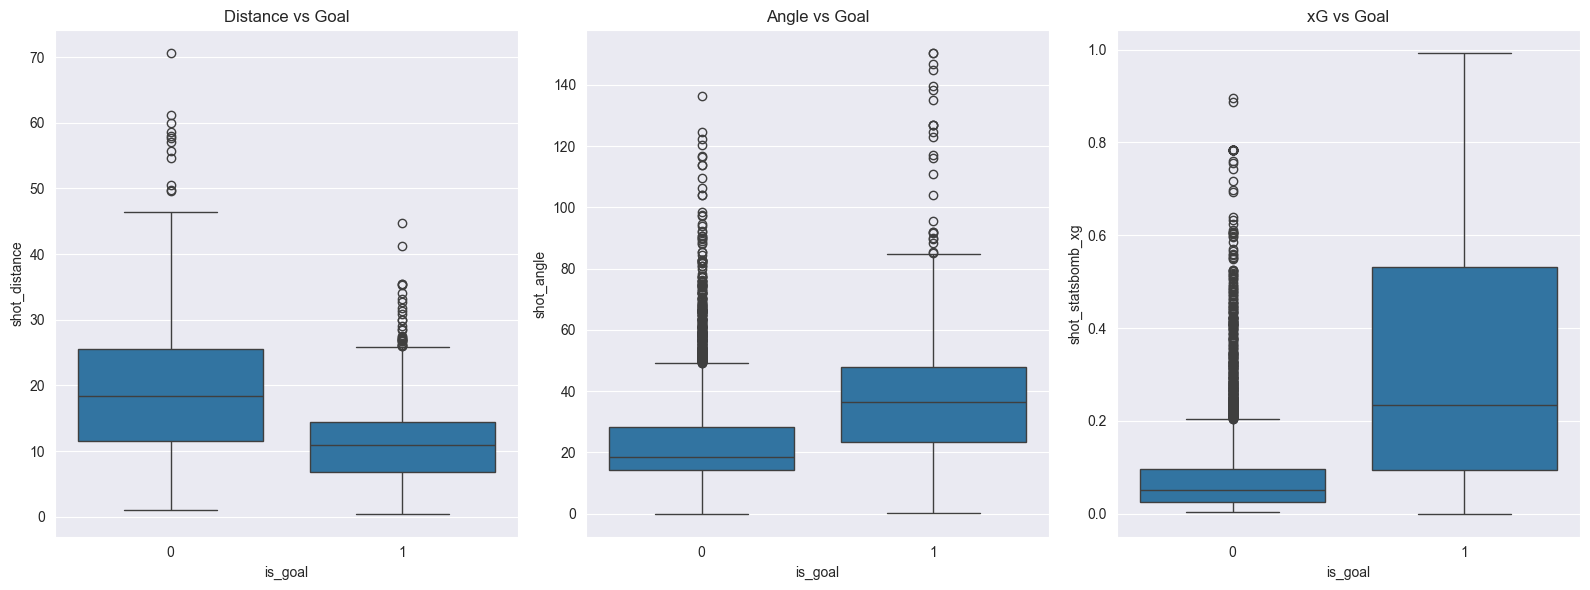

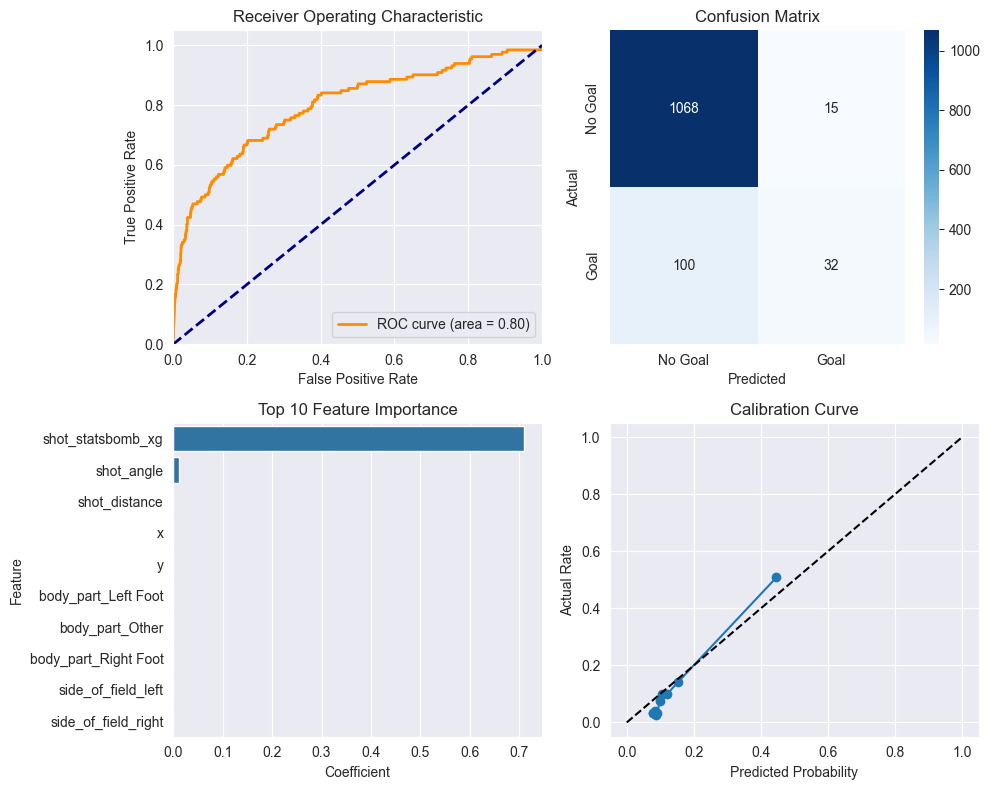

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

# Load the dataset
df = pd.read_csv('all_kicks_dataset_enhanced.csv')

# Step 1: Exploratory Data Analysis (EDA)
print("Dataset shape:", df.shape)
print("\nTarget distribution:")
print(df['is_goal'].value_counts(normalize=True) * 100)

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values[missing_values > 0])

# Basic stats for numerical features
numerical_features = ['x', 'y', 'shot_distance', 'shot_angle', 'shot_statsbomb_xg']
print("\nNumerical features statistics:")
print(df[numerical_features].describe())

# Correlation with target
corr_with_target = pd.DataFrame()
for col in numerical_features:
    corr_with_target.loc[col, 'correlation'] = df[col].corr(df['is_goal'])
print("\nCorrelation with target (is_goal):")
print(corr_with_target.sort_values('correlation', ascending=False))

# Visualize relationship between distance, angle and goals
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='is_goal', y='shot_distance', data=df)
plt.title('Distance vs Goal')

plt.subplot(1, 3, 2)
sns.boxplot(x='is_goal', y='shot_angle', data=df)
plt.title('Angle vs Goal')

plt.subplot(1, 3, 3)
sns.boxplot(x='is_goal', y='shot_statsbomb_xg', data=df)
plt.title('xG vs Goal')

plt.tight_layout()
plt.savefig('feature_vs_goal.png')

# Step 2: Feature Engineering
# Create a copy for model training
model_df = df.copy()

# Handle categorical variables if needed
categorical_features = ['body_part', 'shot_technique', 'side_of_field']
for feature in categorical_features:
    if feature in model_df.columns:
        # Create dummy variables and drop the first to avoid multicollinearity
        dummies = pd.get_dummies(model_df[feature], prefix=feature, drop_first=True)
        model_df = pd.concat([model_df, dummies], axis=1)

# Select features for the model
numerical_model_features = [
    'shot_distance',
    'shot_angle',
    'shot_statsbomb_xg',  # You may want to exclude this if building your own xG model
    'x',
    'y'
]



# Only include features that exist in the dataset

# Get the dummy features we created
dummy_features = [col for col in model_df.columns if any(f"{feat}_" in col for feat in categorical_features)]

# Combine all features
features = numerical_model_features + dummy_features

# Handle any missing features
X = model_df[features].copy()
y = model_df['is_goal']

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Step 4: Create a model pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler()),                   # Scale numerical features
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Step 5: Tune hyperparameters
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'model__penalty': ['l1', 'l2'],              # Regularization type
    'model__solver': ['liblinear', 'saga']       # Solver algorithm
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("\nBest parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Step 6: Evaluate the model
# Cross-validation score
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot confusion matrix
plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Goal', 'Goal'], yticklabels=['No Goal', 'Goal'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Get feature importance
if hasattr(best_model['model'], 'coef_'):
    # Get feature names
    feature_names = X.columns

    # Get coefficients
    coefficients = best_model['model'].coef_[0]

    # Create a DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort by absolute coefficient value
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

    # Plot feature importance
    plt.subplot(2, 2, 3)
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Feature Importance')
    plt.tight_layout()

    print("\nFeature Importance:")
    print(feature_importance.head(10))

# Plot calibration curve (Predicted probability vs Actual rate)
plt.subplot(2, 2, 4)
# Group predictions by decile
df_pred = pd.DataFrame({
    'prob': y_pred_proba,
    'actual': y_test.values
})
df_pred['bin'] = pd.qcut(df_pred['prob'], 10, labels=False)
bin_means = df_pred.groupby('bin').agg({'prob': 'mean', 'actual': 'mean'})
plt.plot(bin_means['prob'], bin_means['actual'], 'o-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Rate')
plt.title('Calibration Curve')

plt.tight_layout()
plt.savefig('model_evaluation.png')

# Step 7: Feature Selection (Optional)
# Use Recursive Feature Elimination to identify the most important features
# This is especially useful if you have many features
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=5)
rfe.fit(best_model['imputer'].transform(X_train), y_train)

# Get the selected features
selected_features = [feature for feature, selected in zip(X.columns, rfe.support_) if selected]
print("\nSelected features by RFE:", selected_features)

# Step 8: Create a simplified model with the most important features
# This can be used for analysis or deployment if performance is similar
X_train_simple = X_train[selected_features]
X_test_simple = X_test[selected_features]

simple_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, **{k.replace('model__', ''): v for k, v in grid_search.best_params_.items()}))
])

simple_pipeline.fit(X_train_simple, y_train)
simple_y_pred = simple_pipeline.predict(X_test_simple)
simple_y_pred_proba = simple_pipeline.predict_proba(X_test_simple)[:, 1]

print("\nSimplified Model Performance:")
print(classification_report(y_test, simple_y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, simple_y_pred_proba):.3f}")

# Step 9: Save the model
import joblib
joblib.dump(best_model, 'free_kick_model.pkl')
print("\nModel saved as 'free_kick_model.pkl'")

# Create a function to predict goal probability for new free kicks
def predict_free_kick_goal_probability(
    x, y, shot_distance, shot_angle,
    body_part='Right Foot', shot_technique='Normal',
    xg=None, **kwargs):
    """
    Predict the probability of scoring from a free kick.

    Parameters:
    - x, y: shot location coordinates
    - shot_distance: distance to goal
    - shot_angle: angle to goal
    - body_part: part used for the shot (default: Right Foot)
    - shot_technique: technique used (default: Normal)
    - xg: StatsBomb xG if available
    - **kwargs: other features from the model

    Returns:
    - Probability of scoring
    """
    # Create a DataFrame with the features
    data = {
        'shot_distance': [shot_distance],
        'shot_angle': [shot_angle],
        'x': [x],
        'y': [y]
    }

    # Add xG if provided
    if xg is not None:
        data['shot_statsbomb_xg'] = [xg]



    # Create dummy variables for categorical features
    if body_part != 'Right Foot':  # Assuming 'Right Foot' is the reference category
        col_name = f'body_part_{body_part}'
        if col_name in dummy_features:
            data[col_name] = [1]

    if shot_technique != 'Normal':  # Assuming 'Normal' is the reference category
        col_name = f'shot_technique_{shot_technique}'
        if col_name in dummy_features:
            data[col_name] = [1]

    # Create DataFrame and fill missing columns
    df_pred = pd.DataFrame(data)

    # Add missing columns
    for feature in features:
        if feature not in df_pred.columns:
            df_pred[feature] = 0

    # Keep only features in the model
    df_pred = df_pred[features]

    # Make prediction
    probability = best_model.predict_proba(df_pred)[0, 1]

    return probability

# Example usage
print("\nExample prediction for a specific free kick:")
example_probability = predict_free_kick_goal_probability(
    x=100, y=40, shot_distance=20, shot_angle=10,
    body_part='Right Foot', shot_technique='Normal',
    xg=0.1, shot_one_on_one=0, under_pressure=1
)
print(f"Goal probability: {example_probability:.3f}")